### Investigate Patterns for important misclassfied transactions
---

We produce the group of transactions the current model perform weakly on in `5-investigate-misclassified`. In this notebook we study the pattern them to build better features.

In [1]:
# !pip uninstall rdsutils --yes
# !pip install -i https://repository.sofi.com/artifactory/api/pypi/pypi/simple rdsutils --no-cache-dir

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3, python_object_to_s3
from rdsutils.analysis import get_misclassified_high_risk_rows, build_summary
from rdsutils.plot import hist_by_target, TransactionsVisualizer

%load_ext autoreload
%autoreload 2

In [3]:
modeling_df = pd.read_parquet('../../artifacts/20200920/modeling_df_w_baseline_preds.parquet')
transactions_df = pd.read_parquet('../../artifacts/20200920/transactions_df_unlabeled.parquet')

In [4]:
deposit_transaction_codes = ['POSDD', 'ACHDD', 'ACHDDIN', 'ACHINDD', 'DDCK', 'DDMBR', 'DD']
withdrawal_transaction_codes = ['POSDW', 'ACHDW', 'ACHDWIN', 'DWATM', 'DWATMI', 'DWCK', 'DWBILLPAY',
                                'DWCRDBILLPAY', 'DWMBR', 'ACHDWP2P', 'DWWIRE', 'DBDWWIRE', 
                                'DWTRF', 'DBDW', 'DWSLROTP', 'DW']
modeling_df['ach_target'] = modeling_df['is_returned']
transactions_df['ach_target'] = transactions_df['is_returned']
transactions_df['ach_target'].fillna(False, inplace=True)

In [5]:
transactions_df['ach_target'].value_counts(dropna=False)

False    15252339
True        42889
Name: ach_target, dtype: int64

#### Look at Highly Confident Ones
---

In [19]:
def get_high_conf_trajectory_info(df):
    target_stats = ['ach_target']
    meta_cols = ['borrower_id', 'business_account_number', 
                 'boruta_pred', 'deposit_v1_pred', 'deposit_v1_updated_pred', 
                 'real_ending_balance', 'transaction_amount']+target_stats
    df = modeling_df[meta_cols]  # no indeterminate here
    df = df.loc[df['ach_target']]  # only look at targets
    df = df.sort_values(by=['boruta_pred', 'transaction_amount'], 
                        ascending=False)
    correctly_classified_df = df
    
    focus_on_df = df.sort_values('boruta_pred', ascending=False)
    focus_on_df['ach_target'] = focus_on_df['ach_target'].astype(float)
    df_by_account = focus_on_df.groupby(['business_account_number'])['ach_target', 'boruta_pred', 
                                                                     'transaction_amount'].agg(['mean', 'count', 'sum'])
    
    # df_by_account = df_by_account.sort_values(by=[('transaction_amount', 'mean')], ascending=False)
    df_by_account = df_by_account.sort_values(by=[('boruta_pred', 'mean')], ascending=False)
    df_by_account = df_by_account[[('ach_target', 'mean'), 
                                   ('boruta_pred', 'mean'), 
                                   ('boruta_pred', 'count'),
                                   ('transaction_amount', 'sum')]]

    df_by_account_ = focus_on_df.groupby(['business_account_number'])[target_stats].agg(['count'])
    df_by_account = pd.merge(df_by_account, df_by_account_, left_index=True, right_index=True)
    return correctly_classified_df, df_by_account

In [24]:
correct_df, cor_df_by_account = get_high_conf_trajectory_info(modeling_df)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [25]:
def drop_non_ach(df):
    return df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]

In [26]:
path = '../../artifacts/20200920/ach-correctly-classified-trajectory.html'
visualizer = TransactionsVisualizer(path,
                                    cor_df_by_account, transactions_df, 
                                    'business_account_number', 
                                    target_col='ach_target',
                                    scatter_filter=drop_non_ach)
visualizer.run(n_samples=1000)

1000it [07:56,  2.10it/s]


#### Group 1: low boruta_pred
---
Compare with `5-investigate-missclassification` side-by-side.

In [6]:
def get_trajectory_info(df):
#     n_days = 60
#     target_stats = [f'target_{n_days}d',
#                    f'is_chg_wrt_off_in_{n_days}d',
#                    f'account_closed_by_risk_in_next_{n_days}d',
#                    f'nr_returns_in_next_{n_days}d',
#                    f'bal_after_{n_days}d']
    target_stats = ['ach_target']
    meta_cols = ['borrower_id', 'business_account_number', 
                 'boruta_pred', 'deposit_v1_pred', 'deposit_v1_updated_pred', 
                 'real_ending_balance', 'transaction_amount']+target_stats
    df = modeling_df[meta_cols]  # no indeterminate here
    df = df.loc[df['ach_target']]  # only look at targets
    df = get_misclassified_high_risk_rows(df, 'transaction_amount', 'boruta_pred')
    misclassified_df = df
    
    focus_on_df = df.sort_values('boruta_pred', ascending=True)
    focus_on_df['ach_target'] = focus_on_df['ach_target'].astype(float)
    df_by_account = focus_on_df.groupby(['business_account_number'])['ach_target', 'boruta_pred', 
                                                                     'transaction_amount'].agg(['mean', 'count', 'sum'])
    
    # df_by_account = df_by_account.sort_values(by=[('transaction_amount', 'mean')], ascending=False)
    df_by_account = df_by_account.sort_values(by=[('boruta_pred', 'mean')], ascending=True)
    df_by_account = df_by_account[[('ach_target', 'mean'), 
                                   ('boruta_pred', 'mean'), 
                                   ('boruta_pred', 'count'),
                                   ('transaction_amount', 'sum')]]

    df_by_account_ = focus_on_df.groupby(['business_account_number'])[target_stats].agg(['count'])
    df_by_account = pd.merge(df_by_account, df_by_account_, left_index=True, right_index=True)
    return misclassified_df, df_by_account

In [7]:
mis_df, df_by_account = get_trajectory_info(modeling_df)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [8]:
mis_df.head()

,borrower_id,business_account_number,boruta_pred,deposit_v1_pred,deposit_v1_updated_pred,real_ending_balance,transaction_amount,ach_target
7753876,38704,410001743824,0.109560,0.005263,0.120669,61011.73,50000.0,True
8747931,7877594,410001959615,0.182500,0.001513,0.285454,75709.75,50000.0,True
7972827,7734122,410001789737,0.216921,0.053258,0.296705,50135.85,50000.0,True
8441021,4674252,410001884084,0.250612,0.004313,0.240452,156225.75,50000.0,True
73917,3116972,410000074416,0.441121,0.013160,0.240653,50919.34,50000.0,True


In [9]:
# account level dataframe, with index being the id
df_by_account.head()

ach_target boruta_pred       transaction_amount  \
                              mean        mean count                sum   
business_account_number                                                   
410000889900                   1.0    0.007645     1             1100.0   
410002006160                   1.0    0.012066     1             1000.0   
410004175867                   1.0    0.012528     1              300.0   
410004891725                   1.0    0.012878     1               50.0   
410002296417                   1.0    0.015322     1              650.0   

                        ach_target  
                             count  
business_account_number             
410000889900                     1  
410002006160                     1  
410004175867                     1  
410004891725                     1  
410002296417                     1

In [10]:
def drop_non_ach(df):
    return df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]

In [12]:
# path = '../../artifacts/20200920/ach-trajectory.html'
path = '../../artifacts/20200920/ach-trajectory-full.html'
visualizer = TransactionsVisualizer(path,
                                    df_by_account, transactions_df, 
                                    'business_account_number', 
                                    target_col='ach_target',
                                    scatter_filter=drop_non_ach)
# visualizer.run(n_samples=100)
visualizer.run()

2923it [23:24,  2.08it/s]


#### Look at individual ids

In [9]:
bid = 410002532273
df = transactions_df[transactions_df.business_account_number == bid].copy()
df.sort_values(by=['transaction_datetime'], ascending=True, inplace=True)
df.head()

,transaction_datetime,user_id,business_account_number,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,external_institution_id,...,nr_returns_in_next_30d,target_30d,indeterminate_30d,account_closed_by_risk_in_next_60d,latest_acc_bal,is_chg_wrt_off_in_60d,bal_after_60d,nr_returns_in_next_60d,target_60d,indeterminate_60d
10566333,2019-09-12 18:01:10,14532591,410002532273,ACHDD,False,100.0,100.00,165838997,100.00,031176110,...,0.0,False,False,False,0.0,False,200.15,0.0,False,False
10566334,2019-09-12 18:01:37,14532591,410002532273,DDRAFNEW,False,50.0,150.00,,150.00,,...,0.0,False,False,False,0.0,False,200.15,0.0,False,False
10566335,2019-10-09 18:01:08,14532591,410002532273,ACHDD,False,50.0,200.15,165838997,200.15,031176110,...,0.0,False,False,False,0.0,False,276.43,0.0,False,False
10566336,2019-11-18 18:04:39,14532591,410002532273,DDRAFCUS,False,50.0,250.43,,250.43,,...,0.0,False,False,False,0.0,False,374.33,0.0,False,False
10566337,2019-11-25 18:01:10,14532591,410002532273,ACHDD,False,26.0,276.43,165838997,276.43,031176110,...,0.0,False,False,False,0.0,False,189.66,0.0,False,False


* does having an external account id affect the result? 
* how about having multiple external account ids?

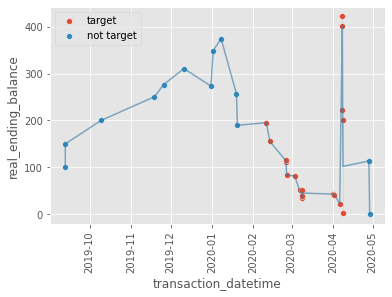

In [10]:
import seaborn as sns

palette = sns.color_palette("mako_r", df.business_account_number.nunique())
sns.lineplot(y='real_ending_balance', x='transaction_datetime', 
             data=df, hue='business_account_number', 
             palette=palette, alpha=0.6, legend=None)
# label target deposits
sns.scatterplot(y='real_ending_balance', x='transaction_datetime', 
                data=df[df.target_60d], label='target')
# label non target deposits
sns.scatterplot(y='real_ending_balance', x='transaction_datetime', 
                data=df[~df.target_60d], label='not target')
plt.xticks(rotation=90)
plt.show()